# PART 1

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)

#### Reading the wikipedia table
1st row of the table is a header, the 1st table from the link page is chosen

In [2]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(link, header=0)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Removing 'Not assigned' boroughs

In [3]:
df = df[df.Borough!='Not assigned'].reset_index(drop=True)

#### Multiple neighborhoods in one postal code area
no duplicate values for Postal Code column, so all neighborhoods from one postal area are already listed in one row

In [4]:
df['Postal Code'].value_counts().head(10) #

M4P    1
M6K    1
M3L    1
M9R    1
M9V    1
M5P    1
M1C    1
M4A    1
M2J    1
M3J    1
Name: Postal Code, dtype: int64

#### 'Not assigned' neighborhoods
There are no neighborhoods labeled as 'Not assigned'

In [5]:
df[df.Neighbourhood=='Not assigned'].count()

Postal Code      0
Borough          0
Neighbourhood    0
dtype: int64

# PART 2

#### Reading the geospacial data and adding it to the general dataframe

In [6]:
latlong = pd.read_csv('Z:\Geospatial_Coordinates.csv')

In [7]:
df = df.merge(latlong, on='Postal Code', how='left')

In [8]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# PART 3

In [9]:
import folium
from geopy.geocoders import Nominatim

#### Getting Toronto's latidute and logitude, building a neighborhood map

In [10]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="trnt")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

## Exploring Toronto neighborhoods

#### Foursquare credits

In [11]:
CLIENT_ID = 'OXLFWOLNGBKWFDNYBU3CLIDOR4MNS5WHJ4L3DLIDCHL1GFN4' 
CLIENT_SECRET = 'PV1VFTJLJVQ4RFSQPUA3BXYTSUURCCH4YKAYMOTWDSGEVFCE' 
VERSION = '20201106'
LIMIT = 100

In [12]:
import requests

#### Getting venues data by latitude and longitude from Foursquare

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

#### The size of the venues data

In [15]:
print(toronto_venues.shape)
toronto_venues.head()

(2139, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### Number of venues per each neighborhood

In [16]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


#### Unique venue categories

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


## Analyzing each neighborhood

#### One hot encoding for the venues

In [18]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2139, 274)


,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Mean frequency for each category by neighborhood

In [19]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped

(96, 274)


,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.

#### Most common venues by neighborhood

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Discount Store
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Sandwich Place,Coffee Shop,Pub,Dog Run,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Juice Bar,Butcher


## Clustering Neighborhoods

#### Determining the optimum number of clusters using elbow method

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

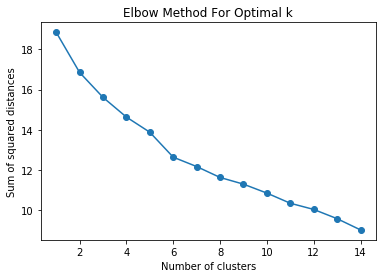

In [23]:
toronto_grouped_clust = toronto_grouped.iloc[:,1:]
ssd = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(toronto_grouped_clust)
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Elbow method tells us the number of clusters = 6, so running kmeans with 6 clusters

In [24]:
k = 6
km = KMeans(n_clusters=k).fit(toronto_grouped_clust)

In [28]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,Intersection,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Spa,Beer Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant,Portuguese Restaurant


#### Visualizing the clusters on the map

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Spa,Beer Store
3,North York,0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,Downtown Toronto,0,Coffee Shop,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant,Portuguese Restaurant
7,North York,0,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Clothing Store,Supermarket,Italian Restaurant,Discount Store,Restaurant,Café
13,North York,0,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Clothing Store,Supermarket,Italian Restaurant,Discount Store,Restaurant,Café
9,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Hotel,Theater,Fast Food Restaurant,Furniture / Home Store
14,East York,0,Skating Rink,Park,Curling Ice,Athletics & Sports,Dance Studio,Intersection,Beer Store,Ethiopian Restaurant,Escape Room,Electronics Store
15,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Cocktail Bar,Beer Bar,Gastropub,American Restaurant,Seafood Restaurant,Farmers Market,Hotel
16,York,0,Field,Hockey Arena,Tennis Court,Dog Run,Trail,Ethiopian Restaurant,Event Space,Escape Room,Electronics Store,Eastern European Restaurant
17,Etobicoke,0,Pharmacy,Liquor Store,Pizza Place,Convenience Store,Beer Store,Coffee Shop,Café,Shopping Plaza,Drugstore,Distribution Center


In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
21,York,1,Park,Women's Store,Pool,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
35,East York,1,Intersection,Park,Convenience Store,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
49,North York,1,Park,Bakery,Construction & Landscaping,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
61,Central Toronto,1,Park,Swim School,Bus Line,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
64,York,1,Park,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
66,North York,1,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
85,Scarborough,1,Park,Playground,Bakery,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
91,Downtown Toronto,1,Park,Playground,Trail,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,2,Intersection,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run
8,East York,2,Pizza Place,Pharmacy,Gastropub,Bus Line,Bank,Breakfast Spot,Athletics & Sports,Intersection,Pet Store,Gym / Fitness Center
10,North York,2,Park,Pizza Place,Japanese Restaurant,Bakery,Pub,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant
29,East York,2,Sandwich Place,Indian Restaurant,Yoga Studio,Grocery Store,Burger Joint,Bus Line,Restaurant,Coffee Shop,Pizza Place,Pharmacy
31,West Toronto,2,Pharmacy,Bakery,Music Venue,Middle Eastern Restaurant,Café,Brewery,Bar,Supermarket,Bank,Park
40,North York,2,Grocery Store,Park,Hotel,Liquor Store,Business Service,Food Truck,Baseball Field,Bank,Athletics & Sports,Shopping Mall
46,North York,2,Grocery Store,Park,Hotel,Liquor Store,Business Service,Food Truck,Baseball Field,Bank,Athletics & Sports,Shopping Mall
53,North York,2,Grocery Store,Park,Hotel,Liquor Store,Business Service,Food Truck,Baseball Field,Bank,Athletics & Sports,Shopping Mall
60,North York,2,Grocery Store,Park,Hotel,Liquor Store,Business Service,Food Truck,Baseball Field,Bank,Athletics & Sports,Shopping Mall
44,Scarborough,2,Bus Line,Bakery,Intersection,Soccer Field,Park,Ice Cream Shop,Metro Station,Bus Station,Doner Restaurant,Donut Shop


In [148]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,3,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Spa,Beer Store
3,North York,3,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,Downtown Toronto,3,Coffee Shop,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Restaurant,Café,Chinese Restaurant,Portuguese Restaurant
7,North York,3,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Clothing Store,Supermarket,Italian Restaurant,Discount Store,Restaurant,Café
13,North York,3,Gym,Japanese Restaurant,Beer Store,Coffee Shop,Clothing Store,Supermarket,Italian Restaurant,Discount Store,Restaurant,Café
9,Downtown Toronto,3,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Hotel,Theater,Fast Food Restaurant,Furniture / Home Store
14,East York,3,Skating Rink,Park,Curling Ice,Athletics & Sports,Dance Studio,Intersection,Beer Store,Ethiopian Restaurant,Escape Room,Electronics Store
15,Downtown Toronto,3,Coffee Shop,Café,Restaurant,Cocktail Bar,Beer Bar,Gastropub,American Restaurant,Seafood Restaurant,Farmers Market,Hotel
16,York,3,Field,Hockey Arena,Tennis Court,Dog Run,Trail,Ethiopian Restaurant,Event Space,Escape Room,Electronics Store,Eastern European Restaurant
17,Etobicoke,3,Pharmacy,Liquor Store,Pizza Place,Convenience Store,Beer Store,Coffee Shop,Café,Shopping Plaza,Drugstore,Distribution Center


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,4,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Health & Beauty Service


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Scarborough,5,Construction & Landscaping,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
57,North York,5,Baseball Field,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Field
101,Etobicoke,5,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
